**Candidate**: André Oliveira Françani


## Description

Many image processing applications make use of digitalized textual data. However, the presence of any type of noise can create difficulties in post-processing information, such as on OCR detection. To improve the information manipulation on such data, a previous image processing step is required.

In light of this idea, a set of text paragraphs containing plain English language was collected. Different font styles, size, and background noise level were arranged to simulate the a variety of scenarios.

## Objective

The objective of this test is to evaluate the possible image processing methods that could fix the text samples. Note that the samples have a different type of background noise and present a set of text fonts. Therefore, the candidate should provide a flexible algorithm that can correctly detect what is text characters and background noise, offering a clean version of each text paragraph as result.

## Important details

- As a common pattern, the text must be represented by BLACK pixels and the background by WHITE pixels. Therefore, the output image MUST be in binary format (i.e. `0` pixel values for text and `255` pixel values for background)
- This test does not require a defined image processing algorithm to be used. The candidate is free to choose any kind of image processing pipeline to reach the best answer.
- The candidate will receive only the noisy data, as clean data is rarely provided on real-case scenarios, and no annotations are provided. Thus, creativity is needed if the candidate chooses to use supervised learning algorithms.
- The perfect correct result is reached with: 1) white background, 2) black text characters, 3) horizontal text aligment, 4) text block centered in the image and 5) straight text font (not itallic formatting).
- Do not change the filename when applying your image processing methods. The filename is important for data comparison purposes.
- The output image file will be only accepted on the following formats: `.png`, `.tif`, `.jpg`

## Implementation


Since we have different background noise, the main idea is to remove this noise using image processing techniques. The first thing I will do is explore the data and try some of these techniques.  

In [1]:
#import libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
from scipy import signal
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
import cv2

### Functions ###
def load_image(image_path):
    '''
    This function loads and normalizes the image given by the 'image_path'.
    '''
    return np.asarray(Image.open(image_path))/255.0

def remove_background(image):
    '''
    This function removes the background noise of the image by applying a Median Filter, and returns 
    a binary denoised image.
    '''
    #Background image
    background_image = signal.medfilt2d(image, kernel_size=13)
    
    #Foreground mask
    mask = image < background_image - 0.2

    #make binary image
    denoised_image = np.where(mask, image, 1.0)
    
    return denoised_image


def image_cleanup(filename):
    '''
    This function reads a image given by the path 'filename', removes its background noise and
    corrects its skew, making an horizontal text alignment.
    '''
    
    #read and filter background noise
    image = load_image(filename)
    denoised_img = remove_background(image)

    #Canny edges detector
    edges = canny(denoised_img)

    #Hough lines
    hough_lines = probabilistic_hough_line(edges)

    #slopes of the line segments
    slopes = [(y2 - y1)/(x2 - x1) if (x2-x1) else 0 for (x1,y1), (x2, y2) in hough_lines]

    #the angle, in degrees, in a circle by which the line is offset
    angles = [np.degrees(np.arctan(theta)) for theta in slopes]

    #most common angle
    hist, bins = np.histogram(angles, bins=180)
    max_idx = np.argmax(hist)
    rotate_angle = bins[max_idx]

    #angle correction for the rotation
    if rotate_angle > 45:
        rotate_angle = -(90-rotate_angle)
    elif rotate_angle < -45:
        rotate_angle = 90 - abs(rotate_angle)

    #image dimensions
    (h, w) = denoised_img.shape[:2]
    center = (w // 2, h // 2)

    #affine matrix of 2D rotation
    M = cv2.getRotationMatrix2D(center, rotate_angle, 1.0)
    rotated_image = cv2.warpAffine(denoised_img.astype('uint8'), M, (w, h), flags=cv2.INTER_CUBIC,borderMode=cv2.BORDER_REPLICATE)  

    return rotated_image

In [2]:
#list all images in "noisy_data" folder
images_path = sorted(glob.glob('noisy_data/*.png'))

Let's visualize three images:

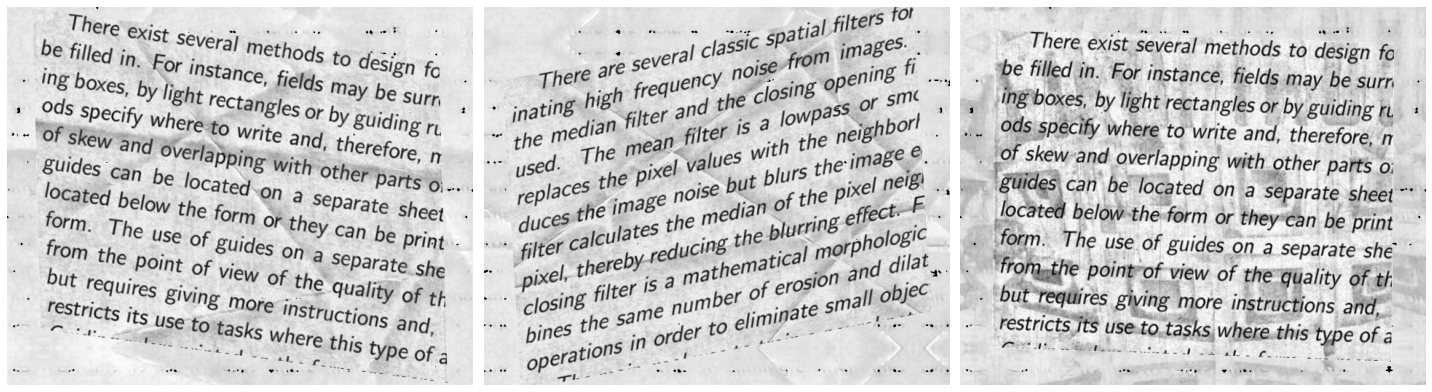

In [3]:
#loading 3 images
img1 = load_image(images_path[0])
img2 = load_image(images_path[1])
img3 = load_image(images_path[2])

#plot images
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img1, 'gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img2, 'gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img3, 'gray')
plt.axis('off')
plt.tight_layout()

Now I will use a *_Median Filter_* to estimate the background of the image 1. The first parameter that I will explore is the *_kernel_size_* of the filter.

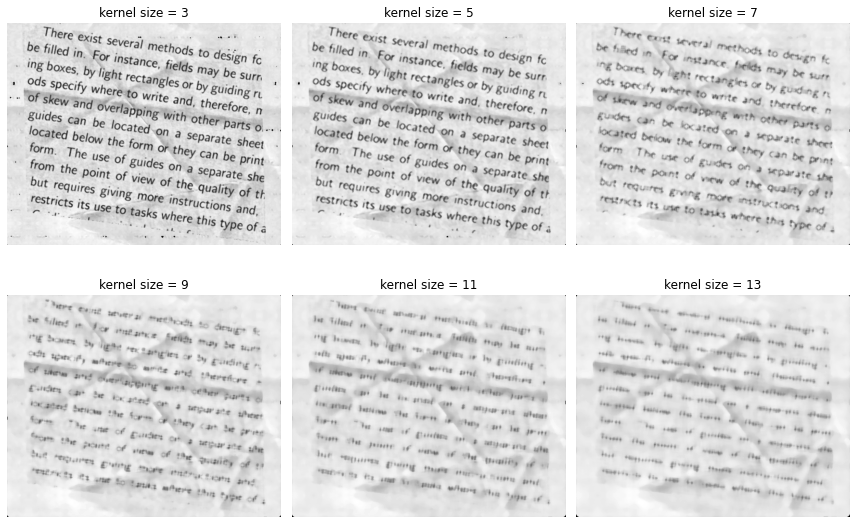

In [4]:
#background image using a median filter
kernel_size = [3, 5, 7, 9, 11, 13]
plt.figure(figsize=(12,8))
for i in range(len(kernel_size)):
    background_img1 = signal.medfilt2d(img1, kernel_size[i])
    plt.subplot(2,3,i+1)
    plt.imshow(background_img1, 'gray')
    plt.axis('off');
    plt.title('kernel size = '+ str(kernel_size[i]))
plt.tight_layout()


From the images above, it can be seen that a kernel (13,13) is good enough to extract the background information without losing significant text information. The next step is to compute the foreground mask, that is, everythig that is significantly darker than the background.

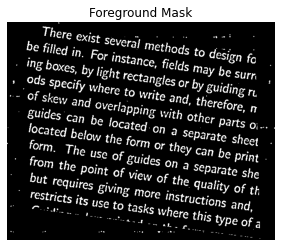

In [5]:
#Foreground mask
mask = img1 < background_img1 - 0.2

plt.imshow(mask, 'gray')
plt.axis('off');
plt.title('Foreground Mask');

Now in the previous image, the black color is a boolean False and the white, True. Therefore I will invert the colors just by making it binary as the following:

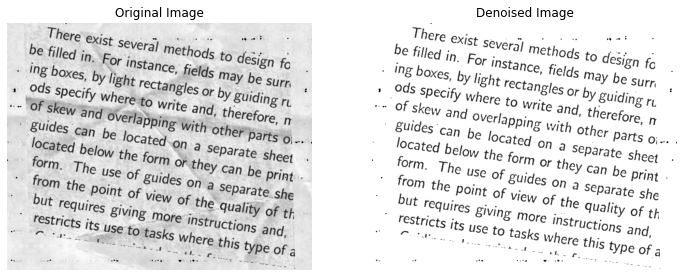

In [6]:
denoised_img1 = np.where(mask, img1, 1.0)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img1, 'gray')
plt.axis('off');
plt.title('Original Image');

plt.subplot(1,2,2)
plt.imshow(denoised_img1, 'gray')
plt.axis('off');
plt.title('Denoised Image');


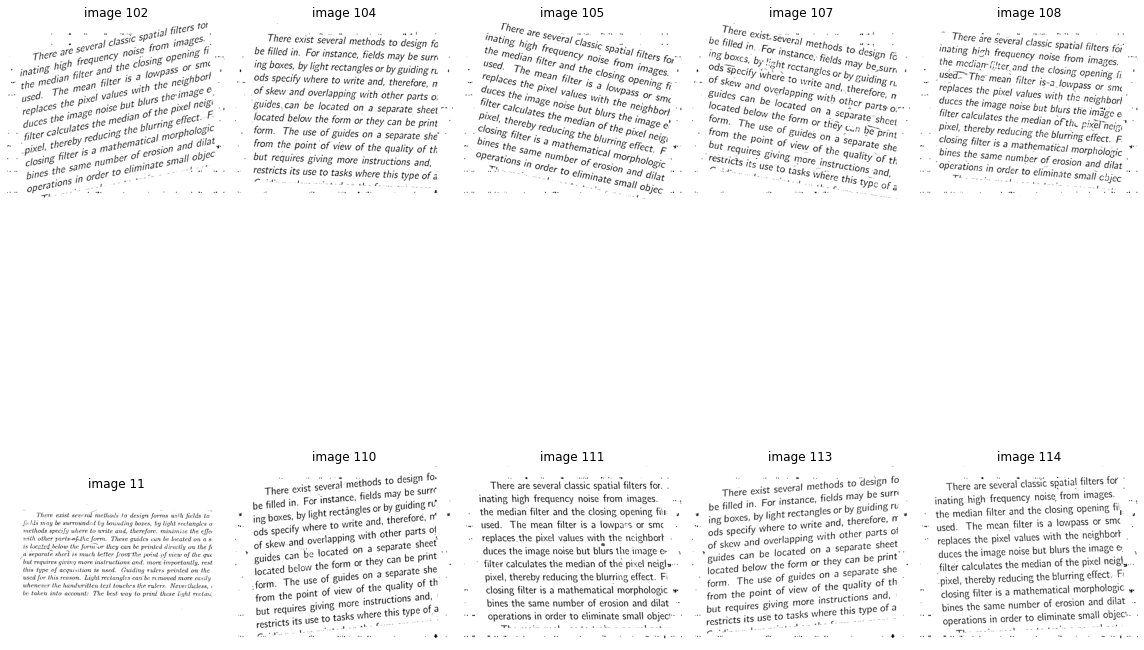

In [7]:
#Display 10 images
plt.figure(figsize=(16,16))
for i in range(1,11):
    img = load_image(images_path[i])
    denoised_img = remove_background(img)
    plt.subplot(2,5,i)
    plt.imshow(denoised_img, 'gray')
    plt.axis('off');
    image_number = images_path[i].split('\\')[1].split('.')[0]
    plt.title('image '+ image_number)
plt.tight_layout()

In [8]:
#Save all denoised images for visual inspection

#folder to save the images
save_folder = 'denoised_data'
if not os.path.exists(save_folder):
        os.makedirs(save_folder)

#remove background of all images and save all of them
for image_path in images_path:
    img = load_image(image_path)
    denoised_image = remove_background(img)
    
    #save Image
    image_name = image_path.split('\\')[1]
    tmp = np.asarray(denoised_image*255.0, dtype=np.uint8)
    Image.fromarray(tmp).save(os.path.join(save_folder, image_name))
    

Assuming that the background is removed, the next step is the **horizontal text alignment**. 

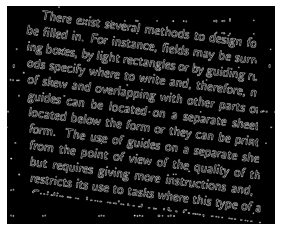

In [9]:
#read and filter background noise
filename = images_path[0]
image = load_image(filename)
denoised_img = remove_background(image)
denoised_image[denoised_img<0] = 0.

#Canny edges detector
edges = canny(denoised_img)

plt.imshow(edges,'gray')
plt.axis('off');

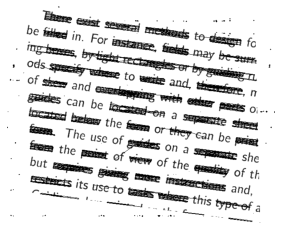

In [10]:
#Hough lines
hough_lines = probabilistic_hough_line(edges)

img_with_lines = np.copy(denoised_img)
for (x1,y1), (x2, y2) in hough_lines:
    cv2.line(img_with_lines,(x1,y1),(x2,y2),(0,0,255),1)
    
plt.imshow(img_with_lines,'gray')
plt.axis('off');


Most common angle:  7.708511579515523


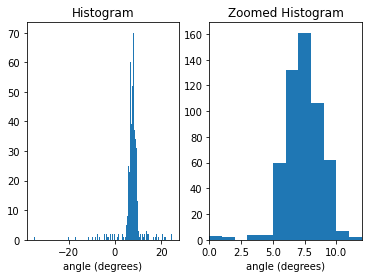

In [11]:
#slopes of the line segments
slopes = [(y2 - y1)/(x2 - x1) if (x2-x1) else 0 for (x1,y1), (x2, y2) in hough_lines]

#the angle, in degrees, in a circle by which the line is offset
angles = [np.degrees(np.arctan(theta)) for theta in slopes]

#which of these degree values is most common?
#histogram of the angles
plt.subplot(1,2,1)
plt.hist(angles, bins=180)
plt.title('Histogram')
plt.xlabel('angle (degrees)')

plt.subplot(1,2,2)
plt.hist(angles, bins=[x for x in range(360)])
plt.xlim([0,12])
plt.title('Zoomed Histogram')
plt.xlabel('angle (degrees)')

#most common angle
hist, bins = np.histogram(angles, bins=180)
max_idx = np.argmax(hist)
rotate_angle = bins[max_idx]

print('Most common angle: ', rotate_angle)

It can be seen that the most frequent angle for this image sample is around 7 degrees. This means that we can rotate the image by this angle to correct the text skew.

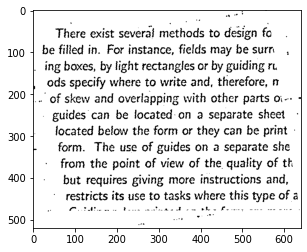

In [12]:
#angle correction for the rotation
if rotate_angle > 45:
    rotate_angle = -(90-rotate_angle)
elif rotate_angle < -45:
    rotate_angle = 90 - abs(rotate_angle)

#image dimensions
(h, w) = denoised_img.shape[:2]
center = (w // 2, h // 2)

#affine matrix of 2D rotation
M = cv2.getRotationMatrix2D(center, rotate_angle, 1.0)
rotated_image = cv2.warpAffine(denoised_img.astype('uint8'), M, (w, h), flags=cv2.INTER_CUBIC,borderMode=cv2.BORDER_REPLICATE)  

plt.imshow(rotated_image,'gray')

Now, I will apply a final function called *_image_cleaunp_* that receives a path to the image, reads and removes its background and correct the skew of the image.

In [13]:
#Save all denoised images for visual inspection

#folder to save the images
save_folder = 'cleaned_data'
if not os.path.exists(save_folder):
        os.makedirs(save_folder)

#cleanup images save them
for image_path in images_path:

    cleaned_image = image_cleanup(image_path)
    
    #save Image
    image_name = image_path.split('\\')[1]
    tmp = np.asarray(cleaned_image*255.0, dtype=np.uint8)
    Image.fromarray(tmp).save(os.path.join(save_folder, image_name))
    

**Notes**: I was not able to straight the text font (not itallic formatting). I tried quickly to apply an unwrap method but had no success. However, comparing the obtained cleaned documents with the original given ones, it can be seen that the cleaned versions are much better than the dirty ones.